In [1]:
import ast #for literal interpretation of string "lists"
import matplotlib.pyplot as plt #for visualization
import networkx as nx #for network analysis
import numpy as np #for associated mathematical analysis, filtering and indexing
import pandas as pd #for working with DataFrames

**Pulling In and Cleaning Data**

Our data for this project comes from the popualar data science hub Kaggle, and contains about 34,000 LinkedIn posts from 69 popular users (or "influencers") on the platform (scraped in February of 2021). While the data does not come readily formatted for network analysis, we believe that the practice of tagging other professionals on LinkedIn will make it ripe for mapping after a bit of tweaking and cleaning. Once we identify every instance of one influencer mentioning another in the text of their posts, we will have a series of edges and nodes we can plot using networkx.

In [2]:
df_LI = pd.read_csv('../data/influencers_data.csv')

/var/folders/sk/5p5s43w94rlf_9j_h77yytpc0000gn/T/ipykernel_14911/1818368662.py:1: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_LI = pd.read_csv('../data/influencers_data.csv')


In [3]:
#df_LI

In [4]:
#clean extra index column
df_LI.drop(columns = 'Unnamed: 0',
           inplace = True)

In [5]:
#see list of LinkedIn influencers
#list(set(df_LI['name']))

In [6]:
#eliminate emoji in Pascal Bouvier's name for sake of consistency
df_LI['name'] = df_LI['name'].apply(lambda x: x.replace('🏉 ', ''))

**Building Edge and Node DataFrames**

The most foundational requirement for building our network is the list of edges, which are defined by LinkedIn influencers mentioning one another in the text of their posts. That means we need to build a system for running through each of those texts and extracting substrings matching our list of influencers (but excluding when influencers may mention themselves. For that, we built a function called *pull_other_influencers*, defined below:

In [7]:
def pull_other_influencers(post_text, inf_self, inf_all):
    '''Create a list of influencers mentioned in post text. Dis-includes
    Influencer who made post on application.'''

    #ensure text is string (can't search it otherwise)
    post_text = str(post_text)
    
    #make copy of inf_all    
    inf_others = inf_all[:]
    #remove self from all to create others list
    inf_others.remove(inf_self)
    
    #create list of influencers_other mentioned in post text
    mentioned_infs = [inf for inf in inf_others if inf in post_text]
    
    return mentioned_infs

In [8]:
#Build a list of the influencers appearing in the dataset.
inf_list = list(set(df_LI['name']))

Now, we can make a new column in our data, with each cell containing a list of influencers mentioned in the post text associated with that row.

In [9]:
#apply influencer pulling function
df_LI['mentioned_influencers'] = df_LI.apply(lambda x: pull_other_influencers(x['content'],
                                                                              x['name'],
                                                                              inf_list),
                                            axis = 1)

Finally, we can create a clean edge dataframe, containing only two columns: *name*,  which captures the speaker or "from" side of the edge, and *mentioned_influencers*, which compiles the "to" sides of the equation. Here, we also limit rows to those in which there are mentioned influencers (denoted by have a list length greater than zero), since an edge requires two sides.

Note that we then need to "explode" the *mentioned_influencers* column, which breaks up the list in each cell. If the list has only one element, this essentially extracts that element. However, when there are multiple elements in the list (in this case, multiple mentioned influencers in the post), the explode method breaks each into a separate row, creating the distinct edges needed for network analysis.

In [10]:
#limit columns to name and mentioned_influencers, and
#limit rows to those with at least one mentioned influencer
df_edges = df_LI.loc[df_LI['mentioned_influencers'].apply(len) > 0][['name', 'mentioned_influencers']]
#explode mentioned_influencers so there is only one edge per row
df_edges = df_edges.explode('mentioned_influencers')

In [11]:
#rename columns to standard practice
df_edges.columns = ['source', 'target']

In [12]:
#reset index
df_edges.reset_index(inplace = True,
                     drop = True)

Now, we can set about creating a dataframe for nodes. At its core, a node dataset can simply be a de-duplicated list of elements appearing in our edge dataset. However, nodes are often associated with metadata that may lend itself to compelling analysis as we dig deeper into our network.

Perhaps the most compelling data in our data is each influencer's listed location. By comparing analysis results across location categories, we may learn something about the relative importance of where someone lives and conducts business to their ease of online connection.

Before we deduplicate our influencers to create a DataFrame of nodes, we first want to ensure that each is associated with at most one locations. If not, we may have to make a quantitative or qualitative judgment in cases of multiples.

In [13]:
#Run a quick test to confirm each influencer has only 1 location in the data
for inf in inf_list:
    df_loc_test = df_LI.loc[df_LI['name'] == inf, ['name', 'location']].drop_duplicates(subset = 'location')
    if len(df_loc_test) != 1:
        print('{0} has {1} unique locations.'.format([inf, str(len(df_loc_test))]))

Because our loop returned no text, we know each person is associated with a maximum of one location. Now, we need to clean the location column, because it appears to have been read in as a series of list-like strings.

In [14]:
#Make null values consistent with non-nulls (string-like lists)
df_LI.loc[df_LI['location'].isnull(), 'location'] = "['Unknown']"

In [15]:
#interpret lists literally, then combine disparate strings for comprehensibility
df_LI['location'] = df_LI['location'].apply(ast.literal_eval)
df_LI['location'] = df_LI['location'].apply(lambda x: ' '.join(x))

In [16]:
len(df_LI['location'].value_counts())

45

Now we have a readable location column. Unfortunately, there are far too many distinct locations (45) to meaningfully break up our number of influencers (69) for categorical analysis; in many cases, it would simply be a comparison between individual nodes.

However, we can do our own grouping to reduce the number of categories and increase the amount of nodes belonging to each group. Because international businesses tend to operate on the basis of timezones, countries and regions, we qualitatively developed **10** grouped location categories adhering to some of these standards, and bucketed them according to these new categorizations.

In [17]:
#build location dataframe for grouping
df_loc = df_LI[['location']].drop_duplicates()

Here, we can use a nesting structure with numPy's *where* method to create a new array based on string matching conditions. When a location contains substrings associated with certain cities, countries, states or continents, np.where will return a defined value, which we set as our desired grouped locations. Our chosen substrings together accounted for all reported locations in the data--for users who did not report a location, we marked it as "unknown".

In [18]:
df_loc['location_grouped'] = np.where(df_loc['location'].str.contains(\
    'Massachusetts|New York|Philadelphia|Atlanta|Charlotte|Miami|Boston|Washington DC',
    case=False,regex=True),"us_east",
    np.where(df_loc['location'].str.contains(\
        'Colorado|Los Angeles|California|Washington|San Francisco|New Mexico|Salt Lake City',
        case=False,regex=True),"us_west",
        np.where(df_loc['location'].str.contains(\
            'British|United Kingdom', case=False,regex=True),"uk",
            np.where(df_loc['location'].str.contains(\
                'Brisbane|Taipei|India|Singapore|Melbourne'),"APAC",
                np.where(df_loc['location'].str.contains(\
                    'Illinois|Chicago|Wisconsin'),"us_midwest",
                    np.where(df_loc['location'].str.contains(\
                        'Hungary|Luxembourg'),"europe",
                        np.where(df_loc['location'].str.contains(\
                            'Tel'),'MENA',
                            np.where(df_loc['location'].str.contains(\
                                'Africa'),'africa',
                                np.where(df_loc['location'].str.contains(\
                                    'Canada'),'canada','unknown')))))))))

Next, we can merge are newly created location DataFrame into our original data. We will deduplicate that data on the "name" column so that we only have one row for each node, and limit the columns to those that are specific at the level of the user rather than the post.

Lastly, because we are only seeking to analyze users with at least one connection in the data (as in, one mentioned of or by another influencer), we can remove names from the nodes data if they do not appear in the edges data.

In [19]:
#merge in new categories
df_LI = df_LI.merge(df_loc, how = 'left')

In [20]:
#create nodes df with new location categories, removing duplicates
df_nodes = df_LI.drop_duplicates(subset = 'name')

In [21]:
#keep only the columns that are specific to the person, not post
df_nodes = df_nodes[['name', 'location_grouped', 'location', 'followers', 
          'connections', 'about','time_spent', ]].reset_index(drop = True)

In [22]:
#only retain nodes that have at least one edge are actually nodes
appears_in_edges = list(set(list(df_edges['source']) + list(df_edges['target'])))
df_nodes = df_nodes[df_nodes['name'].isin(appears_in_edges)]

**Build Network Map**

Now that we have our edges and nodes how we want them, we can build a network map and calculate centrality metrics. 

In [23]:
G = nx.from_pandas_edgelist(df_edges)

Here, we can add the node attributes into the graph, including a new one mapping each grouped location to a particular color.

In [77]:
category_colors = {
    'us_east': 'blue',
    'us_west': 'yellow',
    'uk': 'purple',
    'canada': 'red',
    'APAC': 'green',
    'us_midwest': 'pink',
    'unknown': 'gray',
    'africa': 'orange'
}

In [78]:
#add node attributes
df_nodes2 = df_nodes.set_index('name')
df_nodes2['loc_color'] = df_nodes2['location_grouped'].map(category_colors)
node_attributes = df_nodes2.to_dict(orient = 'index')

In [79]:
nx.set_node_attributes(G, node_attributes)

In [80]:
node_colors = nx.get_node_attributes(G, 'loc_color').values()

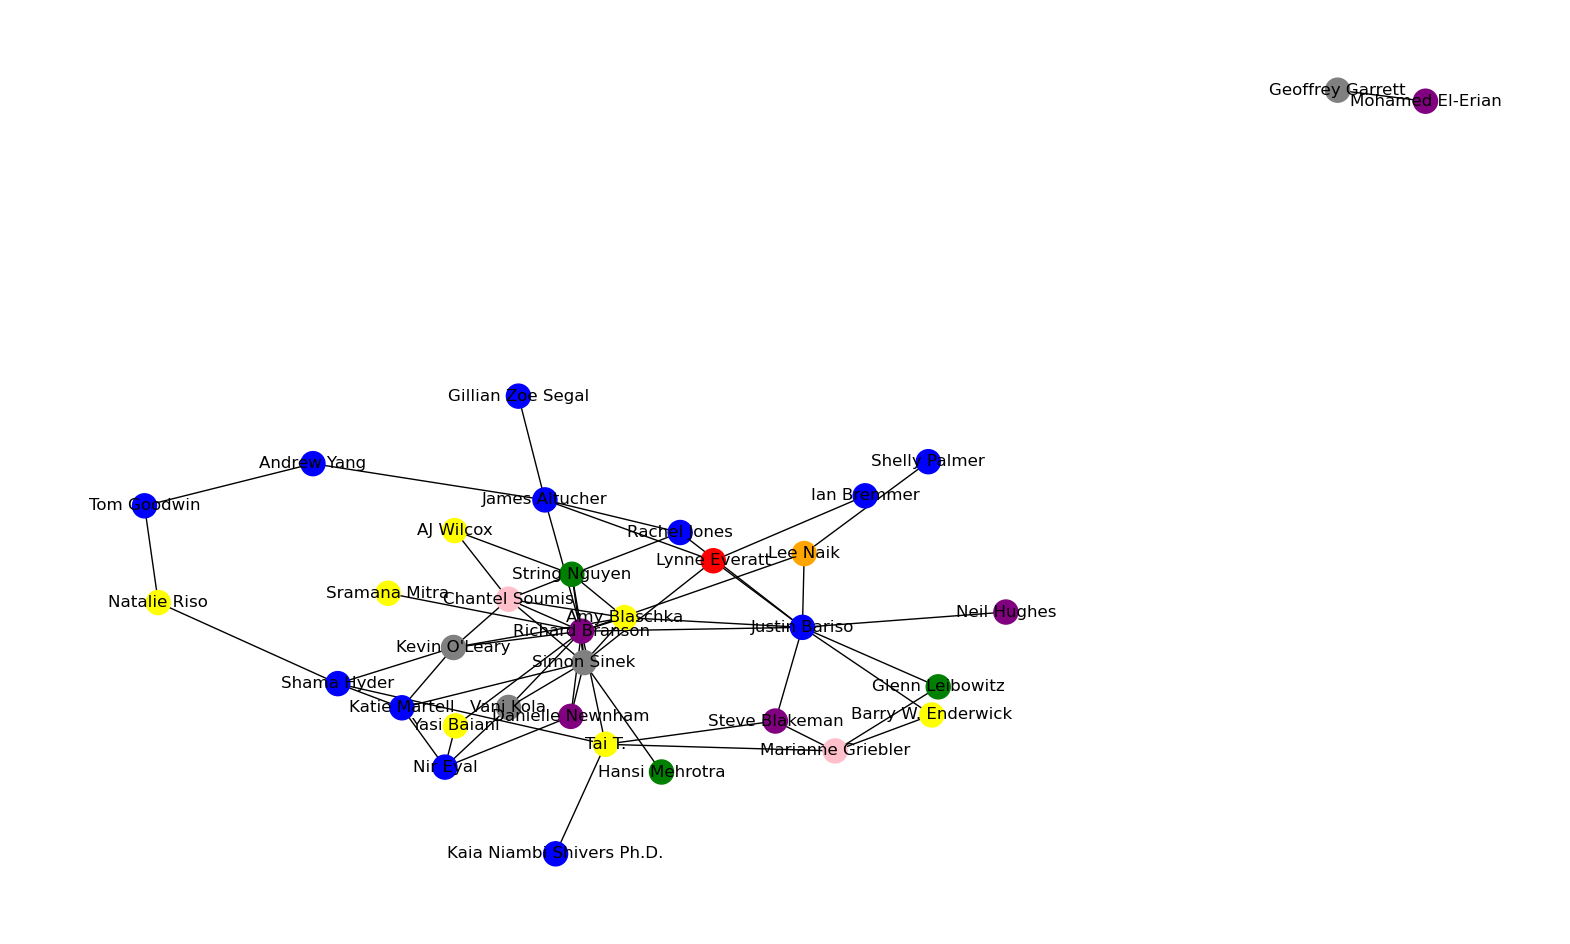

In [86]:
fig, ax = plt.subplots(figsize=(20, 12))
nx.draw(G, with_labels=True, ax=ax, node_color=list(node_colors))

We can observe that our network almost entirely consists of one cluster, save for one dyad between Mohamed El-Erian and Geoffrey Garrett. Given that the vast majority of nodes are connected by some degree, this should make for some interesting centrality analyses. Who is most "popular" in the network? The most connective? The most apparently influential? And do users associated with certain geographies have more "pull" by these measures?

**Calculate Centrality Metrics**

Before we can attempt to answer those questions, we need to calculate centrality metrics. We can do this by looping through networkx's sweet of centrality calculation functions, creating a dictionary for each (associating a node to its value by that metric) and adding that dict as a column to our nodes dataframe.

In [25]:
func_list = [nx.degree_centrality,nx.closeness_centrality,nx.betweenness_centrality,\
             nx.eigenvector_centrality]

# loop through lists
for func in func_list:
    col_name = func.__name__
    result_dict = func(G)
    result = df_nodes['name'].map(result_dict)
    df_nodes[col_name] = result

Now, let's create some top-line rankings for each metric, to see which individuals score the highest in each.

In [26]:
for func in func_list:
    col_name = func.__name__
    df_top5 = df_nodes.sort_values(by = col_name,
                         ascending = False)[['name', col_name]].iloc[:5,:]
    print(df_top5)

               name  degree_centrality
16  Richard Branson           0.382353
68      Simon Sinek           0.264706
23    Justin Bariso           0.264706
67     Amy Blaschka           0.176471
63    String Nguyen           0.176471
               name  closeness_centrality
16  Richard Branson              0.557734
68      Simon Sinek              0.449517
23    Justin Bariso              0.449517
67     Amy Blaschka              0.442907
27           Tai T.              0.424192
               name  betweenness_centrality
16  Richard Branson                0.399465
23    Justin Bariso                0.206318
18   James Altucher                0.150120
27           Tai T.                0.133162
68      Simon Sinek                0.128763
               name  eigenvector_centrality
16  Richard Branson                0.471183
68      Simon Sinek                0.364597
67     Amy Blaschka                0.338023
62   Chantel Soumis                0.317363
63    String Nguyen           

These topline individual rankings tell a few interesting stories about our data.

First of all, there are a number of influencers who rank highly across all four metrics. Immediately, we can see that Richard Branson has a commanding lead in degree, closeness, betweenness and eigenvector centralities. Not only is he incredibly famous--he is arguably biggest "household name" among our nodes--but that popularity seems to extend to LinkedIn mentions, both by and of him. We can confirm that he both mentions and is mentioned by other influencers using the function below.

In [27]:
def count_mentions(name, df_edges):
    '''Report mentions by and mentions of a particular influencer,
    based on a DataFrame of edges'''
    mentions_by = len(df_edges[df_edges['source'] == name])
    mentions_of = len(df_edges[df_edges['target'] == name])
    
    print('mentions by: ' + str(mentions_by))
    print('mentions of: ' + str(mentions_of))

In [28]:
count_mentions('Richard Branson', df_edges)

mentions by: 7
mentions of: 24


Other influencers, such as Simon Sinek and Justin Bariso, are also clearly important in the network across all four metrics, ranking highly in each.

However, perhaps even more interesting are the influencers who rank highly in some metrics but not others. Take James Altucher, for example, who appears in the top 5 only for betweenness centrality. We can see on our network map that he has nowhere near the number of connections as Richard Branson. However, he appears to be incredibly important as a "bridge" node. For example, he is the only connection in the network to Gillian Zoe Segal. He is one of only two connections to Andrew Yang and, via his connection to Rachel Jones, sits closer to certain parts of the map than even users who scored highly in other centrality metrics, like Simon Sinek.

Now observe Chantel Soumis, who has the fourth highest eigenvector centrality, but does not rank in the top 5 in any other metric. Our map shows that compared to some hotly-mentioned and -mentioning influencers, she is a bit on the "outside." But look who she has direct connections to:

In [29]:
list(G.adj['Chantel Soumis'])

['Amy Blaschka',
 'String Nguyen',
 'AJ Wilcox',
 'Simon Sinek',
 "Kevin O'Leary",
 'Richard Branson']

Wow! 4 of Chantel's 6 connections are in the top 5 in degree centrality. It's no wonder her eigenvector centrality was so high--her connections have connections. Looking at a breadth of centrality metrics shows how we can not always judge importance at a glance.

**Compare Centrality Metrics Across Geographies**

While it is no doubt interesting to see the centrality scores for individuals, it is by no means the only way to cut the data. How we analyze our network reflects our use case. If we were a marketing team for a brand wanting to recruit an individual for an activation, perhaps we would use these values to determine who to pitch.

But what if we wanted to know which *region* we should be engaging in more generally? Where is some of the best networking happening on LinkedIn?

For this, we can group our centrality metrics by our newly created location groups and compare across categories.

In [30]:
df_centrality_loc = df_nodes.groupby('location_grouped').mean([['degree_centrality',
                                                  'closeness_centrality',
                                                  'betweenness_centrality',
                                                  'eigenvector_centrality']]).drop(columns = 'followers')

Let's make a couple functions to make repeating our analyses a bit easier as we go.

In [31]:
def sort_and_limit(df_centrality_loc, metric):
    '''Sort a grouped centrality DataFrame by a particular metric,
    and limit to only that metric's column.'''
    return df_centrality_loc.sort_values(by = metric, ascending = False)[[metric]]

In [32]:
def see_individual_metrics(df_nodes, metric):
    '''Sort nodes by particular metric, present names,
    grouped location, and that metric only.'''
    return df_nodes.sort_values(by = metric, ascending = False)[['name', 'location_grouped', metric]]

Degree Centrality

In [33]:
metric = 'degree_centrality'

While the midwest US only has two nodes in the dataset (Chantel Soumis and Marianne Griebler), they are clearly punching above their weight, so to speak. Both are in the top-third by degree centrality. Meanwhile, even though Richard Branson dominates the list of individuals in terms of degree centrality, the other influencers from his geographic cohort weigh down the average for the UK--the next highest Brit is Danielle Newnham, ranked 17th.

In [34]:
sort_and_limit(df_centrality_loc, metric)

,degree_centrality
location_grouped,
us_midwest,0.147059
unknown,0.132353
uk,0.123529
canada,0.117647
us_east,0.090686
africa,0.088235
APAC,0.088235
us_west,0.084034


In [35]:
see_individual_metrics(df_nodes, metric).iloc[:10, :]

,name,location_grouped,degree_centrality
16,Richard Branson,uk,0.382353
68,Simon Sinek,unknown,0.264706
23,Justin Bariso,us_east,0.264706
67,Amy Blaschka,us_west,0.176471
63,String Nguyen,APAC,0.176471
62,Chantel Soumis,us_midwest,0.176471
66,Kevin O'Leary,unknown,0.147059
18,James Altucher,us_east,0.147059
27,Tai T.,us_west,0.147059
22,Lynne Everatt,canada,0.117647


Closeness Centrality

In [36]:
metric = 'closeness_centrality'

Canada and Africa had the highest closeness centrality on average, but each region has only one member, meaning individual metrics are equivalent to group metrics. The Western United States also ranked highly here, do largely to high closeness centrality values for Amy Blaschka and Tai T., with strong to moderate performance in the metric by others in the region. On average, this suggests that influencers in the Western US would very efficiently pass information across to and from other influencers (and not necessarily just others in the Western US).

In [37]:
sort_and_limit(df_centrality_loc, metric)

,closeness_centrality
location_grouped,
canada,0.406995
africa,0.401569
us_midwest,0.372833
us_west,0.356163
APAC,0.347228
us_east,0.332910
uk,0.326160
unknown,0.318012


In [38]:
see_individual_metrics(df_nodes, metric).iloc[:10, :]

,name,location_grouped,closeness_centrality
16,Richard Branson,uk,0.557734
68,Simon Sinek,unknown,0.449517
23,Justin Bariso,us_east,0.449517
67,Amy Blaschka,us_west,0.442907
27,Tai T.,us_west,0.424192
18,James Altucher,us_east,0.418301
62,Chantel Soumis,us_midwest,0.418301
66,Kevin O'Leary,unknown,0.406995
22,Lynne Everatt,canada,0.406995
63,String Nguyen,APAC,0.406995


Betweenness Centrality

In [39]:
metric = 'betweenness_centrality'

For betweenness centrality (relative to other metrics), higher scores for Brits across the board buoy Richard Branson's already very high marks to give the UK an overall lead. This suggests that the UK-based influencers in the network often find themselves in bridging positions from one section of the map to another.

In [40]:
sort_and_limit(df_centrality_loc, metric)

,betweenness_centrality
location_grouped,
uk,0.085094
canada,0.080927
africa,0.055258
unknown,0.046149
us_east,0.045606
us_west,0.028101
us_midwest,0.024370
APAC,0.015233


In [41]:
see_individual_metrics(df_nodes, metric).iloc[:10, :]

,name,location_grouped,betweenness_centrality
16,Richard Branson,uk,0.399465
23,Justin Bariso,us_east,0.206318
18,James Altucher,us_east,0.150120
27,Tai T.,us_west,0.133162
68,Simon Sinek,unknown,0.128763
22,Lynne Everatt,canada,0.080927
32,Shama Hyder,us_east,0.074230
53,Lee Naik,africa,0.055258
66,Kevin O'Leary,unknown,0.042320
57,Andrew Yang,us_east,0.042038


Eigenvector Centrality

In [42]:
metric = 'eigenvector_centrality'

Unfortunately, there's little we can tell about the collective properties of nodes with unknown locations; their only known similarity is an unwillingness to report it on their profile. However, we do also see high marks in eigenvector centrality for the US Midwest, UK and APAC. This is APAC's highest-ranking metric, bolstered by String Nguyen and middle-of-the-pack values for Hansi Mehrotra and Glenn Leibowitz. Here, we can see that users with low degree centrality can nonetheless have high eigenvector centrality by virtue of one or several very important connections (such as Simon Sinek for Hansi Mehrotra or Justin Barosa for Glenn Leibowitz.

In [43]:
sort_and_limit(df_centrality_loc, metric)

,eigenvector_centrality
location_grouped,
unknown,0.191025
us_midwest,0.185075
uk,0.150252
APAC,0.138618
canada,0.134383
africa,0.129278
us_west,0.117227
us_east,0.079174


In [44]:
see_individual_metrics(df_nodes, metric).iloc[:10, :]

,name,location_grouped,eigenvector_centrality
16,Richard Branson,uk,0.471183
68,Simon Sinek,unknown,0.364597
67,Amy Blaschka,us_west,0.338023
62,Chantel Soumis,us_midwest,0.317363
63,String Nguyen,APAC,0.299910
23,Justin Bariso,us_east,0.246759
66,Kevin O'Leary,unknown,0.236425
54,Danielle Newnham,uk,0.163078
55,Vani Kola,unknown,0.163078
31,Katie Martell,us_east,0.137791


**Conclusion**

Centrality metrics tell us a lot about an individual's place in a network, but when combined with categorical variables, they can be even more powerful and explanatory. Mean differences across categories in network metrics can help guide meaningful recommendations; in the case of our LinkedIn map, they could steer an aspiring influencer toward engaging in particular geographies, or guide a researcher toward new potential areas of study. Analyses like these are a reminder that when working with a network map, we should be constantly calibrating our scope between individual nodes, the entire map, and everything in between.